In [1]:
import torch
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

import requests
import os

from celluloid import Camera
from IPython.display import HTML
from base64 import b64encode

In [4]:
import sys
sys.path.append('..')
from mix_NCA.NCA import NCA
from mix_NCA.utils_images import train_nca, standard_update_net
from mix_NCA.MixtureNCA import MixtureNCA
from mix_NCA.RobustnessAnalysis import RobustnessAnalysis


#reload modules if change jupyter kernel
%load_ext autoreload
%autoreload 2





In [5]:
def load_emoji(path, target_size=40, padding=6):
    """
    Load and preprocess emoji image to RGBA tensor with padding
    Args:
        path: path to emoji image
        target_size: desired size of emoji (without padding)
        padding: number of pixels to pad on each side
    Returns:
        Padded tensor of shape (1, 4, H+2*padding, W+2*padding)
    """
    img = Image.open(path).convert('RGBA')
    img = img.resize((target_size, target_size), Image.Resampling.LANCZOS)
    img_tensor = torch.from_numpy(np.array(img)) / 255.0
    
    # Convert to (1, 4, H, W) format
    img_tensor = img_tensor.permute(2, 0, 1).unsqueeze(0)
    
    # Add padding with zeros
    padded_tensor = torch.nn.functional.pad(
        img_tensor, 
        (padding, padding, padding, padding), 
        mode='constant', 
        value=0
    )
    
    return padded_tensor.float()

In [6]:
def download_emoji(emoji_code, save_dir='../data/raw/emojis/'):
    """
    Download a single emoji from Twemoji
    emoji_code: Unicode code point (e.g., '1F600' for grinning face)
    """
    os.makedirs(save_dir, exist_ok=True)
    
    # Twemoji URL format
    url = f'https://raw.githubusercontent.com/twitter/twemoji/master/assets/72x72/{emoji_code.lower()}.png'
    save_path = os.path.join(save_dir, f'{emoji_code}.png')
    
    response = requests.get(url)
    if response.status_code == 200:
        with open(save_path, 'wb') as f:
            f.write(response.content)
        return save_path
    else:
        raise Exception(f"Failed to download emoji: {response.status_code}")


In [7]:
def plot_emoji(tensor):
    """
    Plot a tensor containing RGBA image data
    tensor shape should be (1, 4, H, W) or (4, H, W)
    """
    if len(tensor.shape) == 4:
        # If batch dimension exists, take first image
        tensor = tensor[0]
    
    # Convert tensor to numpy and ensure it's on CPU
    if torch.is_tensor(tensor):
        img = tensor.cpu().detach().numpy()
    else:
        img = tensor
    
    # Reshape to (H, W, 4)
    img = img.transpose(1, 2, 0)
    
    # Create figure with white background
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [8]:
# Set up training parameters
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TARGET_SIZE = 40
N_CHANNELS = 16  
BATCH_SIZE = 8
POOL_SIZE = 1000 
PADDING = 4
NUM_STEPS = [30, 50]
SEED_LOC = (20,20)
GAMMA = 0.2
DECAY = 3e-5
DROPOUT = 0.2
HIDDEN_DIM = 128
TOTAL_STEPS = 6000
PRINT_EVERY = 200
SEED = 3
MILESTONES = [3000, 4000, 5000]
LEARNING_RATE = 1e-3
N_RULES = 5

# set pytorch, numpy and python seeds
torch.manual_seed(SEED)
np.random.seed(SEED)


In [9]:
emoji_path = download_emoji(emoji_code='1F433')
target = load_emoji('../data/raw/emojis/1F433.png', target_size=TARGET_SIZE).to(DEVICE)

In [10]:
target.shape

torch.Size([1, 4, 52, 52])

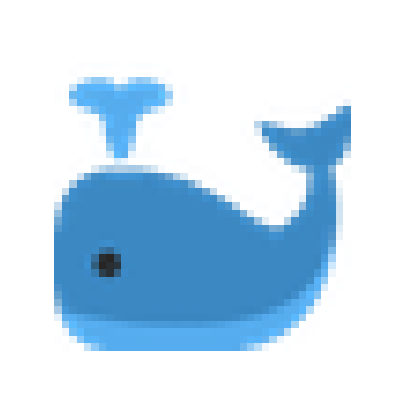

In [11]:
plot_emoji(target)

In [12]:
model = NCA(update_net=standard_update_net(N_CHANNELS* 3, HIDDEN_DIM, N_CHANNELS, device=DEVICE), 
            state_dim=N_CHANNELS, 
            hidden_dim=HIDDEN_DIM, 
            dropout=DROPOUT, 
            device=DEVICE)


In [13]:
loss_nca = train_nca(model, target, device=DEVICE, 
           num_steps=NUM_STEPS, 
           milestones=MILESTONES, 
           learning_rate=LEARNING_RATE, 
           gamma=GAMMA, 
           decay=DECAY, 
           total_steps=TOTAL_STEPS, 
           print_every=PRINT_EVERY, 
           batch_size = BATCH_SIZE, 
           state_dim = N_CHANNELS, 
           seed_loc = SEED_LOC, 
           pool_size = POOL_SIZE
           )



step 0, dt 0.358s, loss 3.67e+03, log10(loss) 3.57
step 200, dt 8.142s, loss 8.32e-02, log10(loss) -1.08
step 400, dt 7.771s, loss 6.54e-02, log10(loss) -1.18
step 600, dt 7.960s, loss 7.30e-02, log10(loss) -1.14
step 800, dt 8.336s, loss 4.59e-02, log10(loss) -1.34
step 1000, dt 8.235s, loss 4.32e-02, log10(loss) -1.36
step 1200, dt 7.872s, loss 4.73e-02, log10(loss) -1.33
step 1400, dt 7.733s, loss 4.02e-02, log10(loss) -1.40
step 1600, dt 8.029s, loss 3.04e-02, log10(loss) -1.52
step 1800, dt 7.753s, loss 2.57e-02, log10(loss) -1.59
step 2000, dt 7.710s, loss 2.70e-02, log10(loss) -1.57
step 2200, dt 7.863s, loss 3.11e-02, log10(loss) -1.51
step 2400, dt 7.937s, loss 2.79e-02, log10(loss) -1.56
step 2600, dt 8.048s, loss 5.64e-02, log10(loss) -1.25
step 2800, dt 8.029s, loss 3.04e-02, log10(loss) -1.52
step 3000, dt 8.449s, loss 2.79e-02, log10(loss) -1.55
step 3200, dt 8.401s, loss 2.06e-02, log10(loss) -1.69
step 3400, dt 8.568s, loss 2.70e-02, log10(loss) -1.57
step 3600, dt 8.54

In [28]:
model_mix = MixtureNCA(update_nets=standard_update_net, 
            state_dim=N_CHANNELS, 
            num_rules = N_RULES,
            hidden_dim=HIDDEN_DIM, 
            dropout=DROPOUT, 
            device=DEVICE, temperature=1)


In [30]:
loss_mix_nca = train_nca(model_mix, target, device=DEVICE, 
           num_steps=NUM_STEPS, 
           milestones=MILESTONES, 
           learning_rate=LEARNING_RATE, 
           gamma=GAMMA, 
           decay=DECAY, 
           total_steps=TOTAL_STEPS, 
           print_every=PRINT_EVERY, 
           batch_size = BATCH_SIZE, 
           state_dim = N_CHANNELS, 
           seed_loc = SEED_LOC, 
           pool_size = POOL_SIZE,
           temperature = 1,
           min_temperature = 1,
           anneal_rate = 0.01,
           straight_through = True
           )


step 0, dt 0.145s, loss 1.69e+01, log10(loss) 1.23
step 200, dt 29.058s, loss 7.27e-02, log10(loss) -1.14
step 400, dt 28.842s, loss 4.92e-02, log10(loss) -1.31
step 600, dt 29.202s, loss 4.62e-02, log10(loss) -1.34
step 800, dt 28.519s, loss 2.67e-02, log10(loss) -1.57
step 1000, dt 28.759s, loss 3.81e-02, log10(loss) -1.42
step 1200, dt 28.535s, loss 3.55e-02, log10(loss) -1.45
step 1400, dt 29.020s, loss 3.02e-02, log10(loss) -1.52
step 1600, dt 29.040s, loss 2.28e-02, log10(loss) -1.64
step 1800, dt 29.282s, loss 2.03e-02, log10(loss) -1.69
step 2000, dt 29.329s, loss 1.59e-02, log10(loss) -1.80
step 2200, dt 29.464s, loss 2.44e-02, log10(loss) -1.61
step 2400, dt 29.568s, loss 2.15e-02, log10(loss) -1.67
step 2600, dt 29.060s, loss 2.47e-02, log10(loss) -1.61
step 2800, dt 28.630s, loss 1.69e-02, log10(loss) -1.77
step 3000, dt 28.326s, loss 1.91e-02, log10(loss) -1.72
step 3200, dt 28.799s, loss 1.80e-02, log10(loss) -1.75
step 3400, dt 28.819s, loss 1.76e-02, log10(loss) -1.75
s

In [31]:
def plot_img(img, fig=None, k=0, dpi=100):
  if fig is None:
    fig = plt.figure(dpi=dpi)
  if k > 0:
    img = img[k:-k,k:-k]
  plt.imshow(img) ; plt.axis('off')
  plt.tight_layout()
  return fig

def zoom(x, k=15):
  return x[...,k:-k,k:-k] if k>0 else x

def to_rgb(x):
  rgb, a = x[..., :3,:,:], x[..., 3:4,:,:].clip(0,1)
  return (1.0-a+rgb).clip(0,1)  # assume rgb premultiplied by alpha

def make_video(frames, path, interval=60, fig=None, **kwargs):
  if fig is None:
    fig = plt.figure(figsize=[3.25, 3.25], dpi=100)
  camera = Camera(fig)
  for i in range(len(frames)):
    fig = plot_img(frames[i], fig=fig, dpi=80)
    camera.snap()
  anim = camera.animate(blit=True, interval=interval, **kwargs)
  anim.save(path)
  plt.close()

In [32]:
model_mix = model_mix.to(DEVICE)

In [33]:
# Construct a video of our CA's growth
init_state = torch.zeros(1, N_CHANNELS, *target.shape[-2:]).to(DEVICE)
init_state[...,3:, SEED_LOC[0], SEED_LOC[1]] = 1 # initially, there is just one cell

frames = model_mix(init_state.to(DEVICE), 400, SEED_LOC, return_history=True).cpu().detach().numpy()
frames = zoom(to_rgb(frames),k=PADDING-5).squeeze(1)  # output has axes [time, rgb, width, height]
frames = frames.transpose(0,2,3,1)

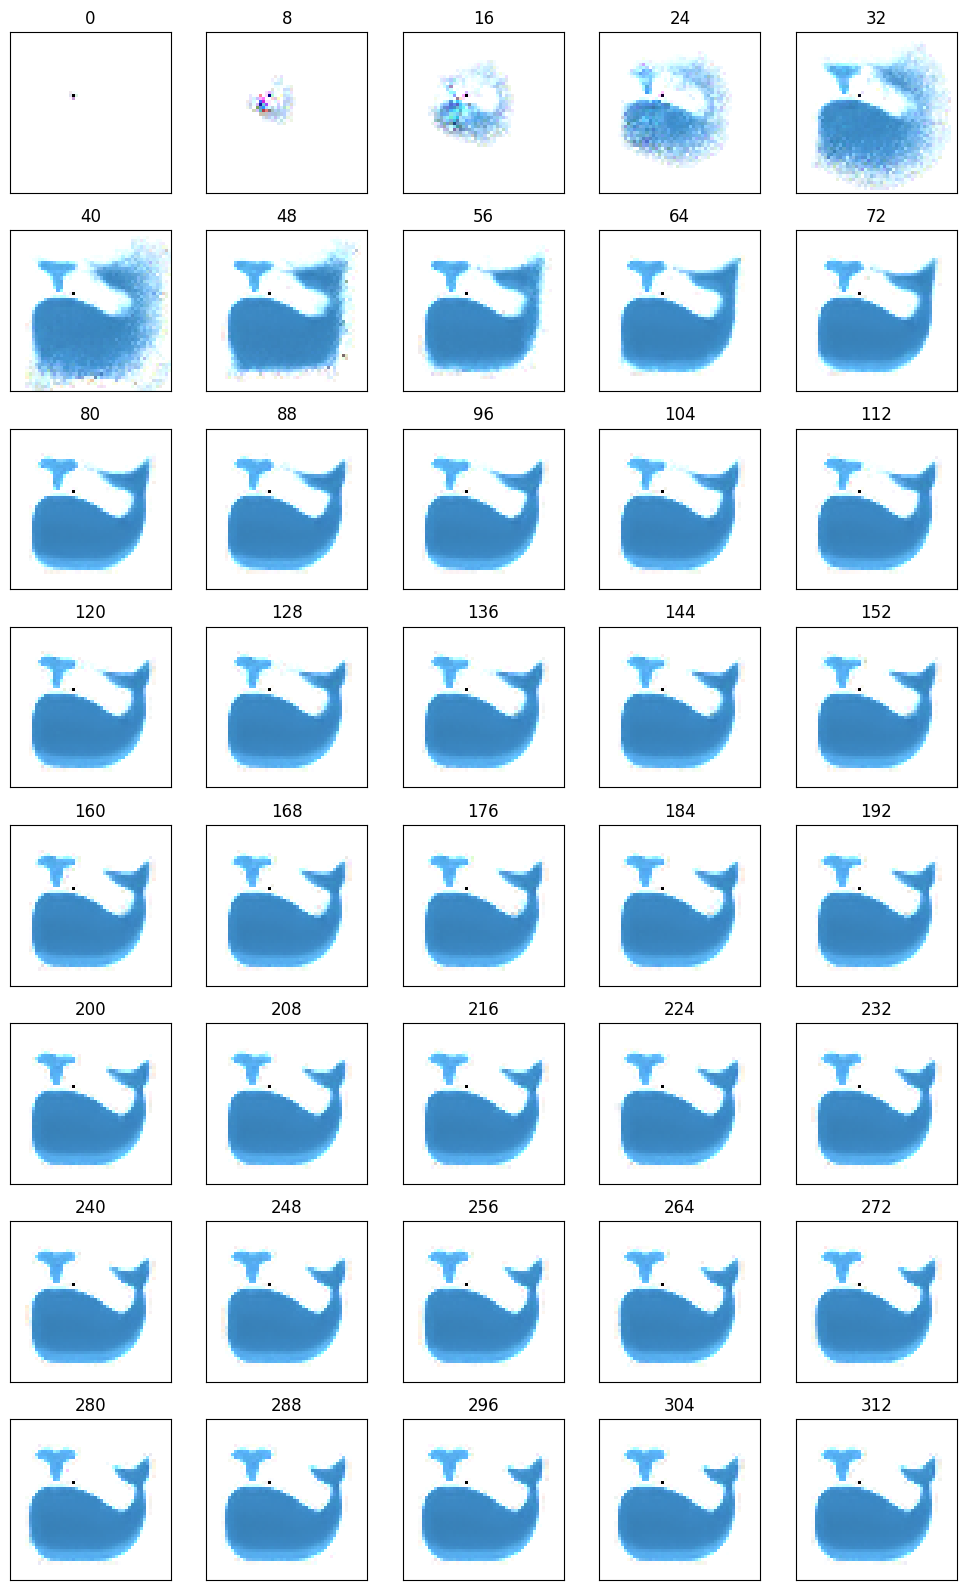

In [34]:
plot_every = 8
frames_ = frames[::plot_every]

rows, cols = 8, 5
fig = plt.figure(figsize=[2*cols, 2*rows], dpi=100)
for i in range(rows):
  for j in range(cols):
    ix = 1 + i*cols + j
    if frames_.shape[0] >= ix:
      plt.subplot(rows,cols,ix)
      plt.xticks([],[]) ; plt.yticks([],[])
      plt.title(plot_every*(ix-1))
      plt.imshow(frames_[ix-1])

plt.tight_layout() ; plt.show()

In [35]:
# Construct a video of our CA's growth
#init_state = torch.zeros(1, N_CHANNELS, *target.shape[-2:]).to(DEVICE)
init_state = target.to(DEVICE)
init_state[...,3:, SEED_LOC[0], SEED_LOC[1]] = 1 # initially, there is just one cell

#init_state_nca = mixture_model(init_state, 400, SEED_LOC, return_history=False).detach()
# fill extra channel dimension with zeros to match standard nca
init_state_nca = torch.cat([init_state, torch.zeros(1, N_CHANNELS - 4, *init_state.shape[-2:]).to(DEVICE)], dim=1)
init_state_nca.shape


torch.Size([1, 16, 52, 52])

In [51]:
robustness_analysis = RobustnessAnalysis(
    standard_nca=model.to(DEVICE),
    mixture_nca=model_mix.to(DEVICE),
    stochastic_mixture_nca=model_mix.to(DEVICE),
    device=DEVICE
)

# Compute metrics once
deletion_results = robustness_analysis.compute_robustness_metrics(
    init_state_nca.to(DEVICE), 
    'deletion', 
    n_runs=30, 
    size=20,
    steps = 100,
    seed = SEED_LOC
    
)

noise_results = robustness_analysis.compute_robustness_metrics(
    init_state_nca.to(DEVICE),
    'noise',
    n_runs=30,
    noise_level=0.05,
    steps = 100,
    seed = SEED_LOC
)



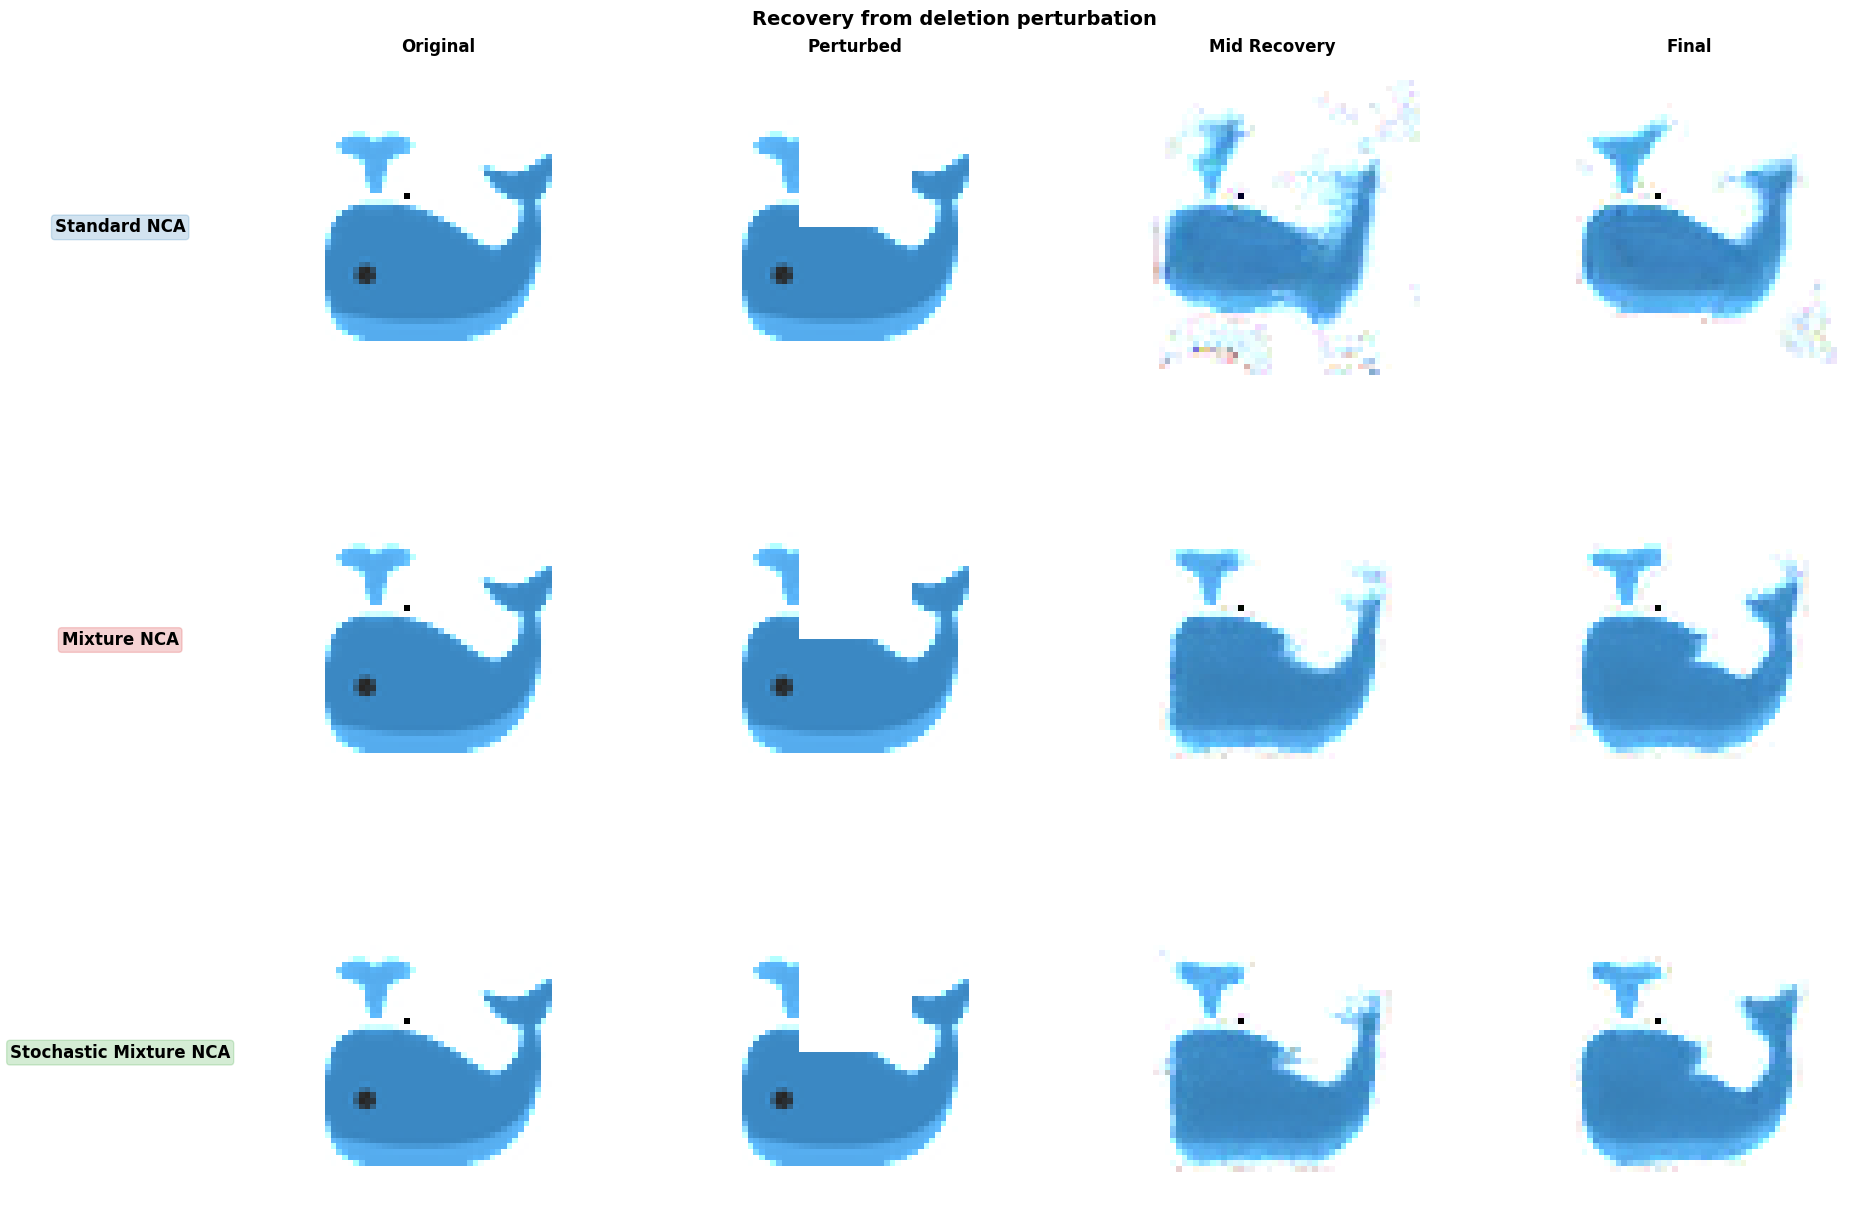

In [52]:
fig, ax = robustness_analysis.visualize_stored_results(deletion_results, plot_type='trajectories')

(<Figure size 2000x1400 with 19 Axes>, <Axes: >)

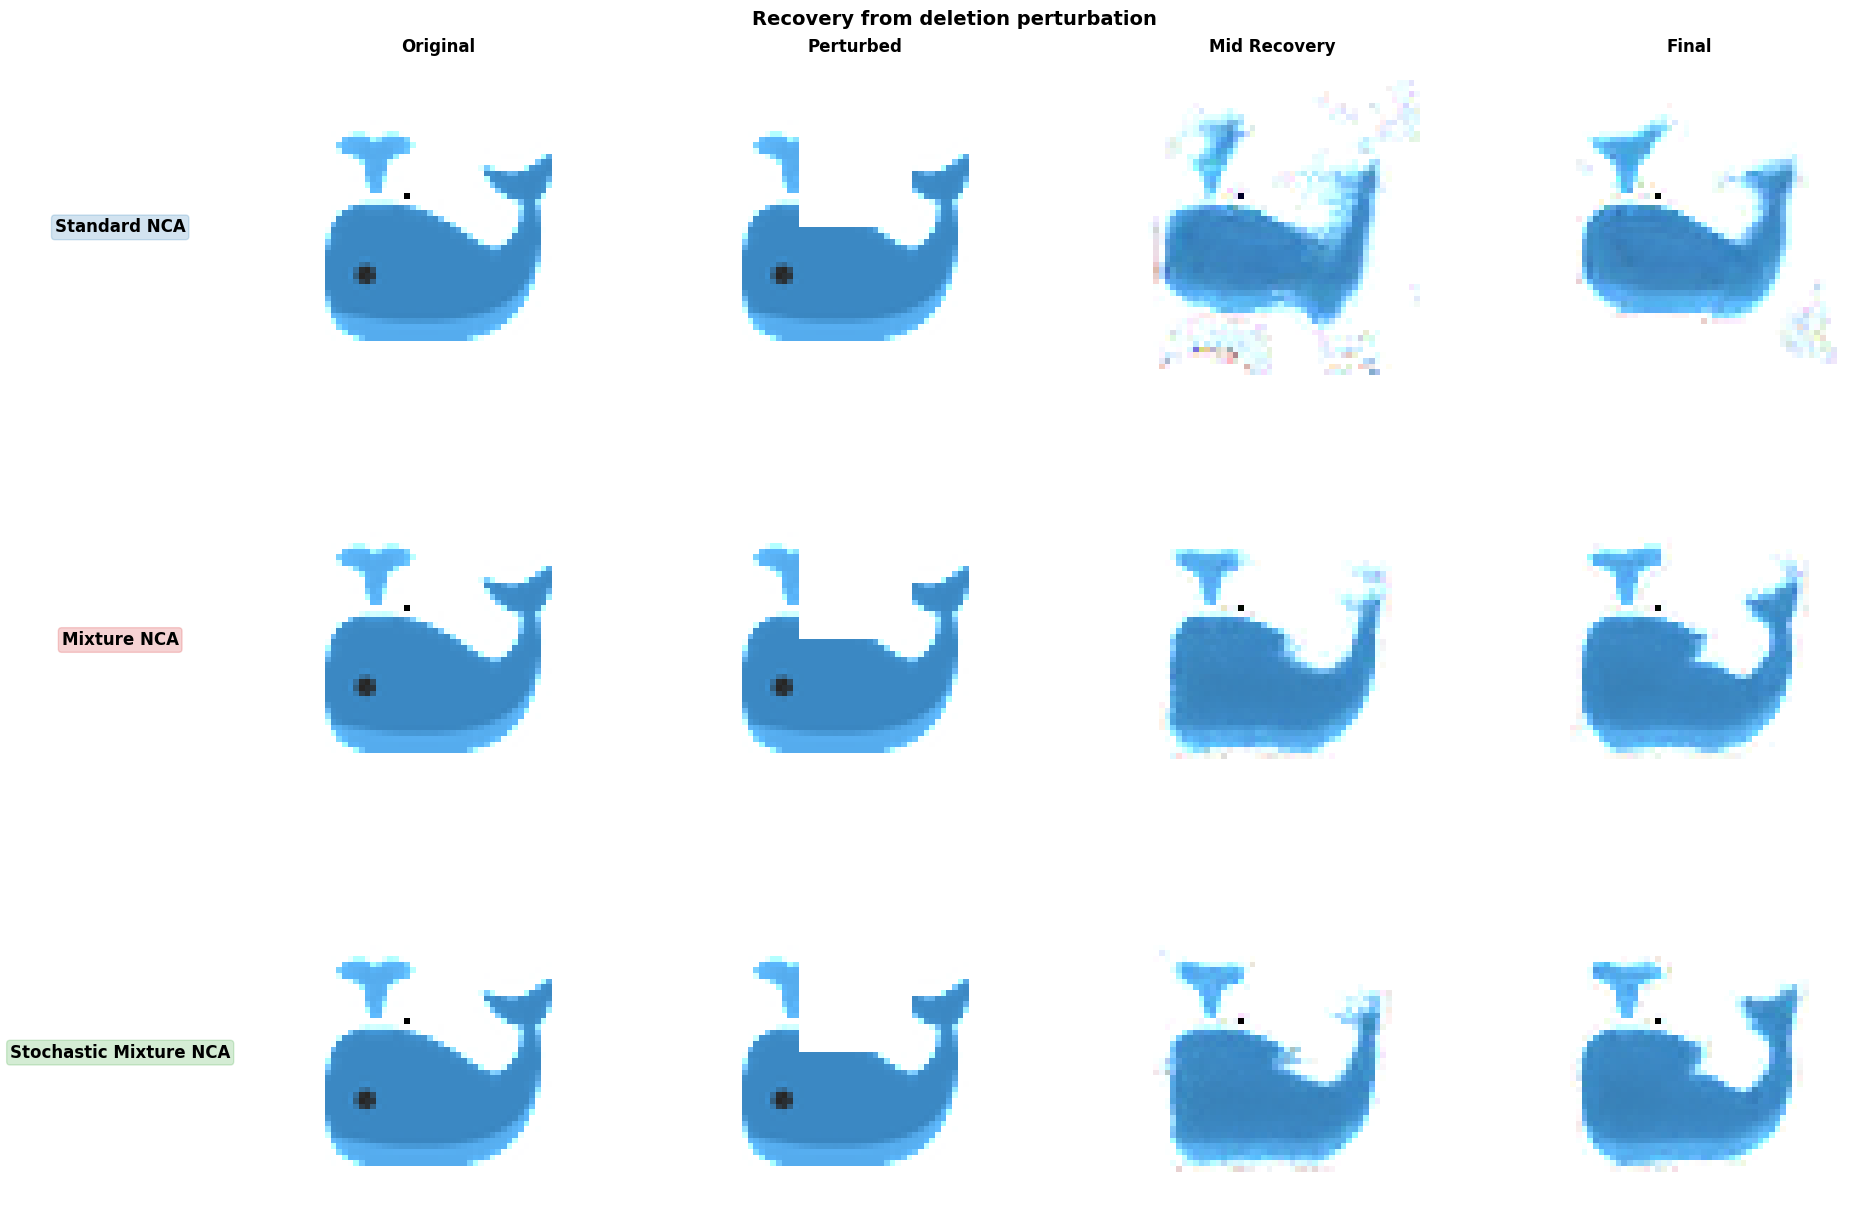

In [53]:
robustness_analysis.visualize_stored_results(deletion_results, plot_type='trajectories')


(<Figure size 2000x1400 with 1 Axes>,
 <Axes: title={'center': 'Recovery from deletion perturbation'}, xlabel='Time Step', ylabel='Recovery Error'>)

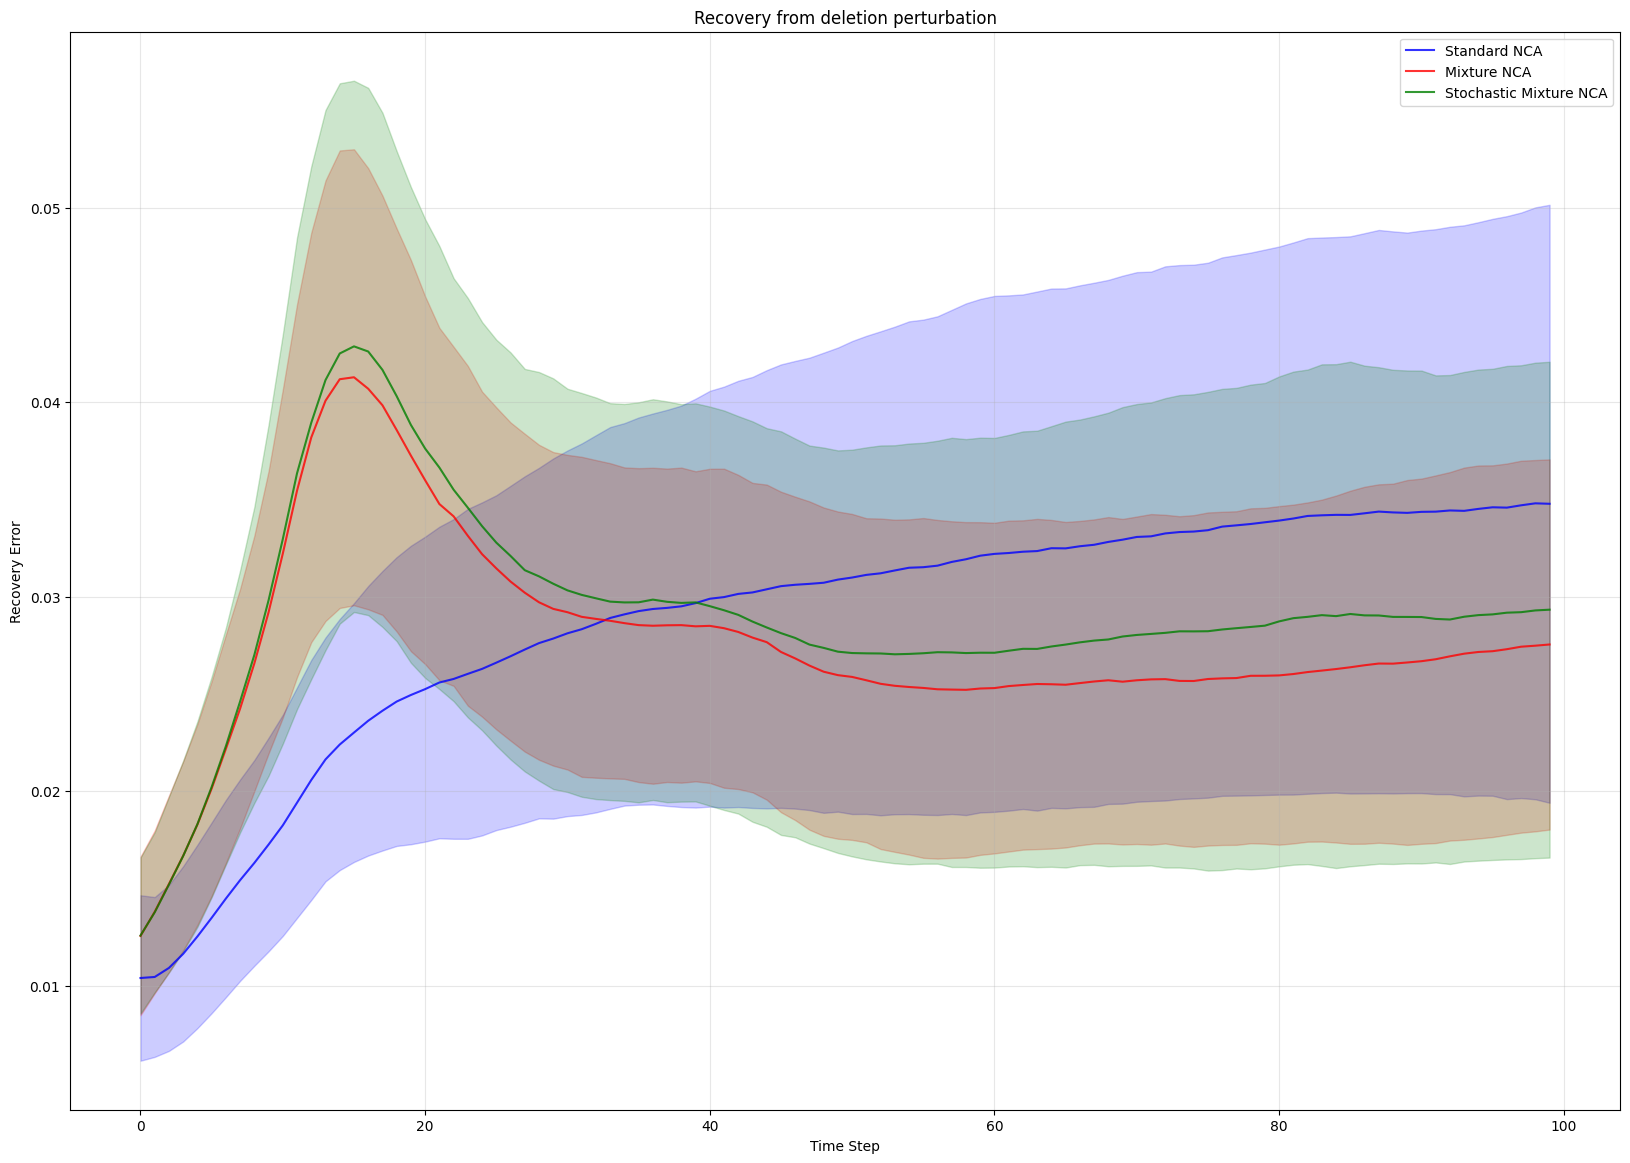

In [54]:
robustness_analysis.visualize_stored_results(results=deletion_results, plot_type='error')


(<Figure size 2000x1400 with 19 Axes>, <Axes: >)

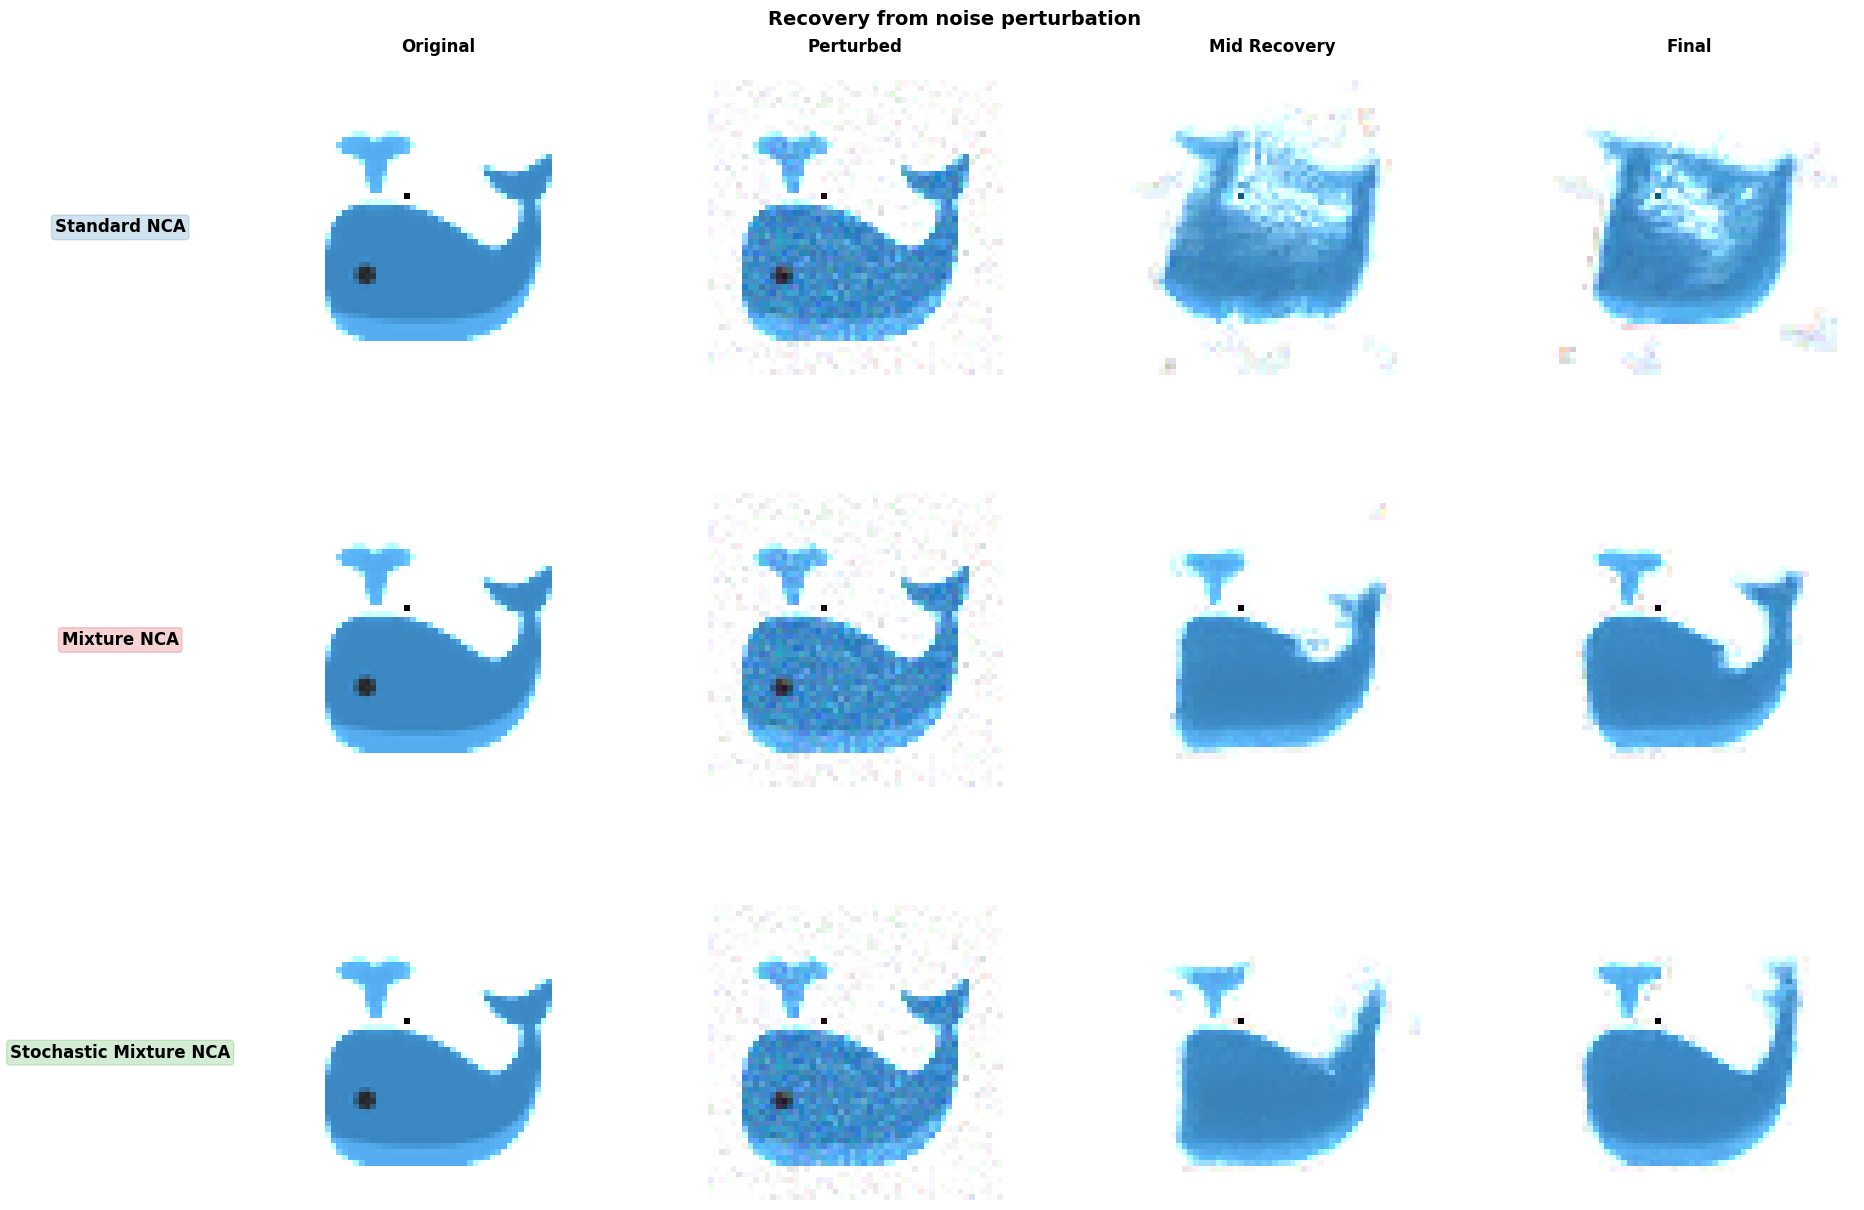

In [55]:
robustness_analysis.visualize_stored_results(noise_results, plot_type='trajectories')

(<Figure size 2000x1400 with 1 Axes>,
 <Axes: title={'center': 'Recovery from noise perturbation'}, xlabel='Time Step', ylabel='Recovery Error'>)

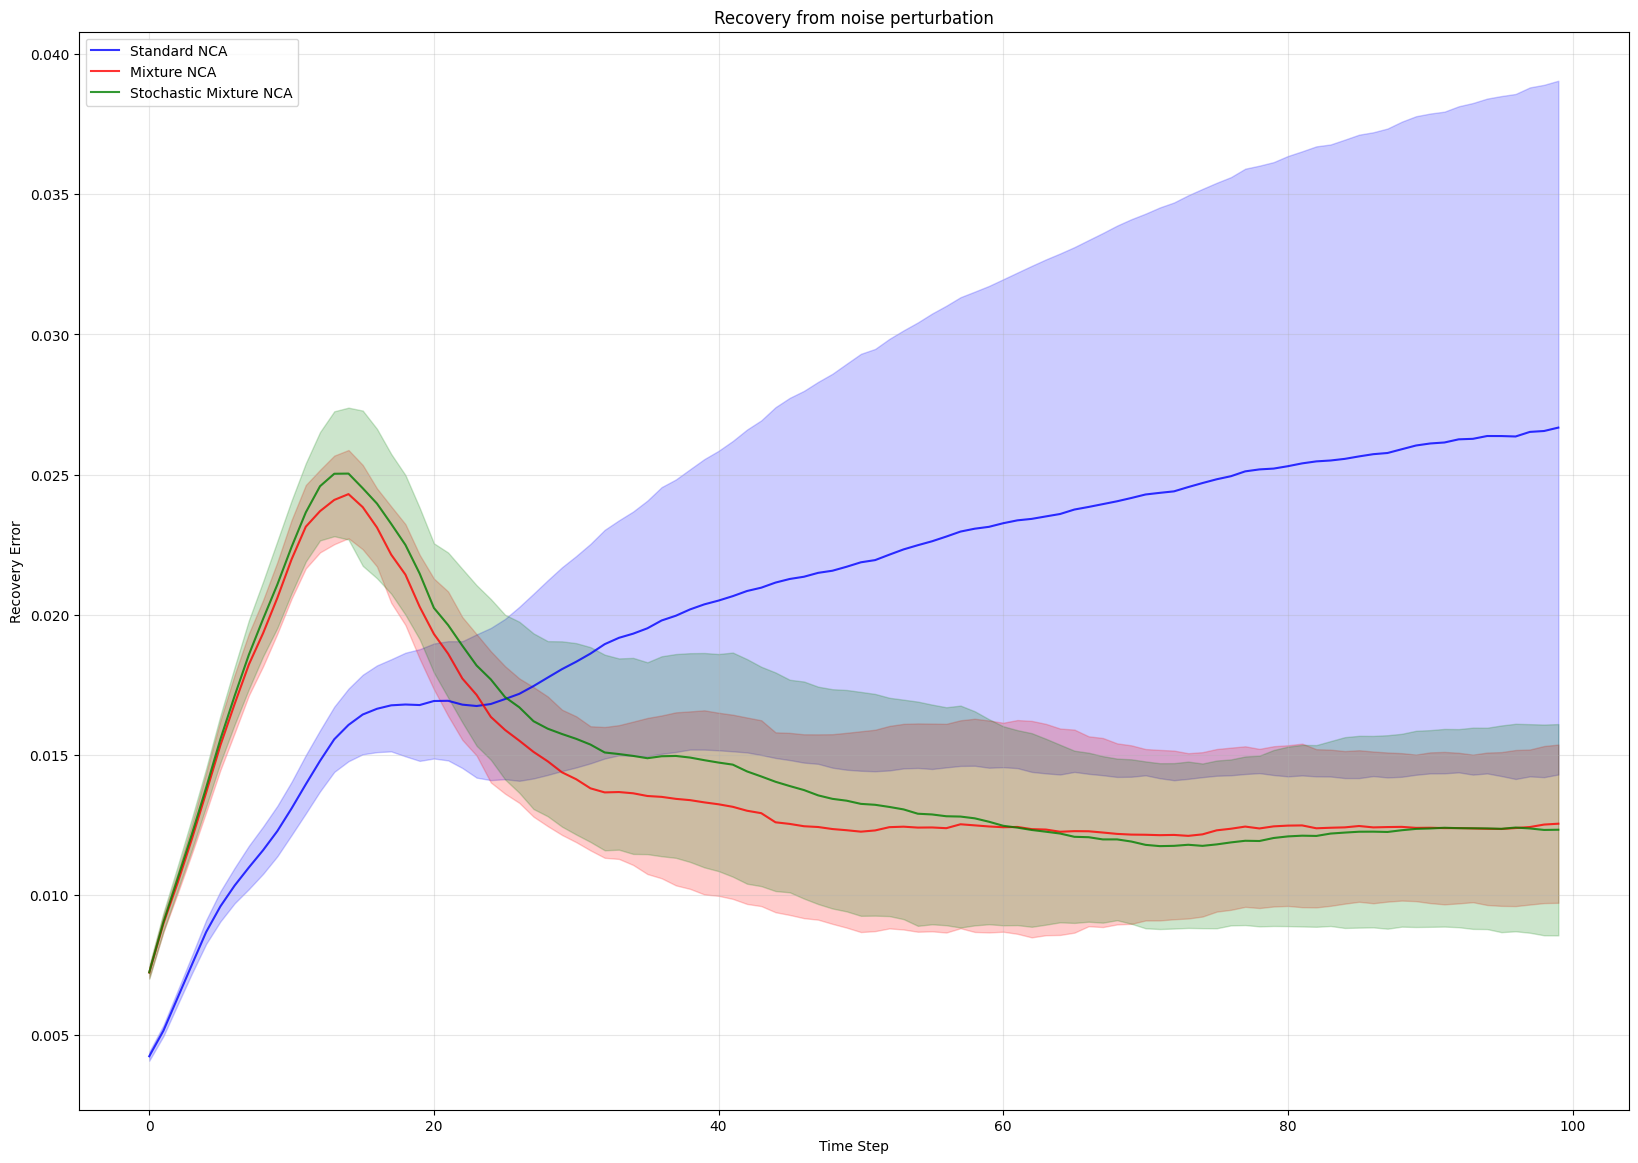

In [56]:
robustness_analysis.visualize_stored_results(noise_results, plot_type='error')


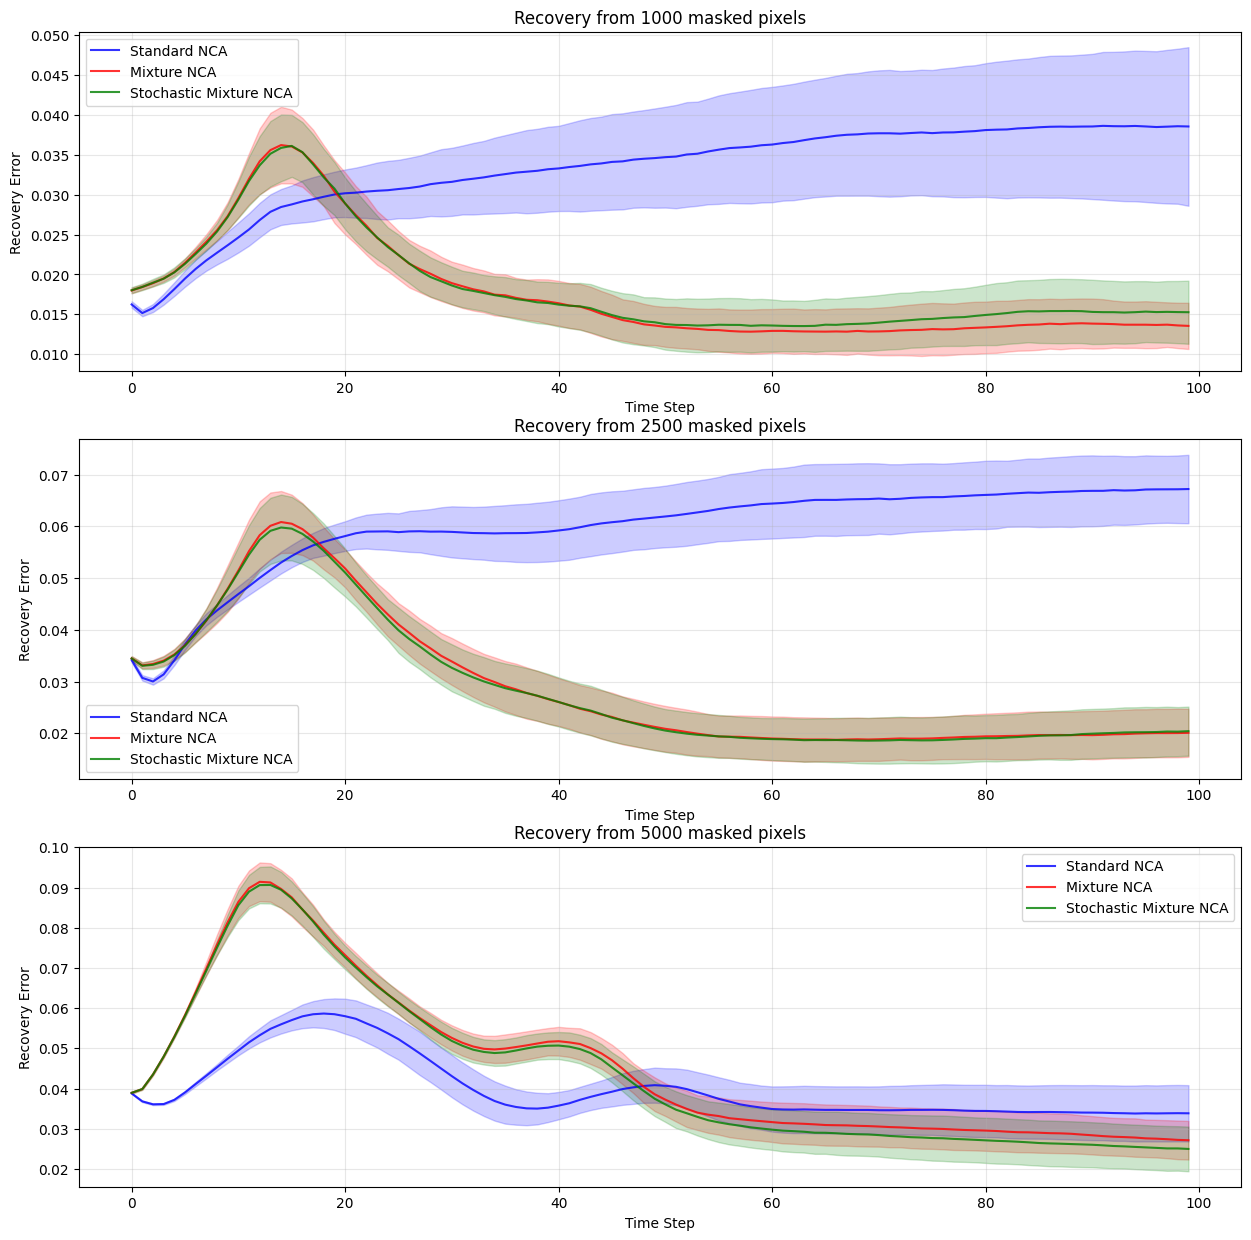

<Figure size 2000x1400 with 0 Axes>

<Figure size 2000x1400 with 0 Axes>

<Figure size 2000x1400 with 0 Axes>


Results for 1000 masked pixels:

Summary Statistics for random_pixels perturbation:

Standard NCA:
Average final error: 0.0386
Average recovery time: 0.0 steps

Mixture NCA:
Average final error: 0.0135
Average recovery time: 0.0 steps

Stochastic Mixture NCA:
Average final error: 0.0153
Average recovery time: 0.0 steps

Results for 2500 masked pixels:

Summary Statistics for random_pixels perturbation:

Standard NCA:
Average final error: 0.0672
Average recovery time: 0.0 steps

Mixture NCA:
Average final error: 0.0201
Average recovery time: 0.0 steps

Stochastic Mixture NCA:
Average final error: 0.0204
Average recovery time: 0.0 steps

Results for 5000 masked pixels:

Summary Statistics for random_pixels perturbation:

Standard NCA:
Average final error: 0.0339
Average recovery time: 0.0 steps

Mixture NCA:
Average final error: 0.0272
Average recovery time: 0.0 steps

Stochastic Mixture NCA:
Average final error: 0.0250
Average recovery time: 0.0 steps


(<Figure size 2000x1400 with 1 Axes>,
 <Axes: title={'center': 'Recovery from random_pixels perturbation'}, xlabel='Time Step', ylabel='Recovery Error'>)

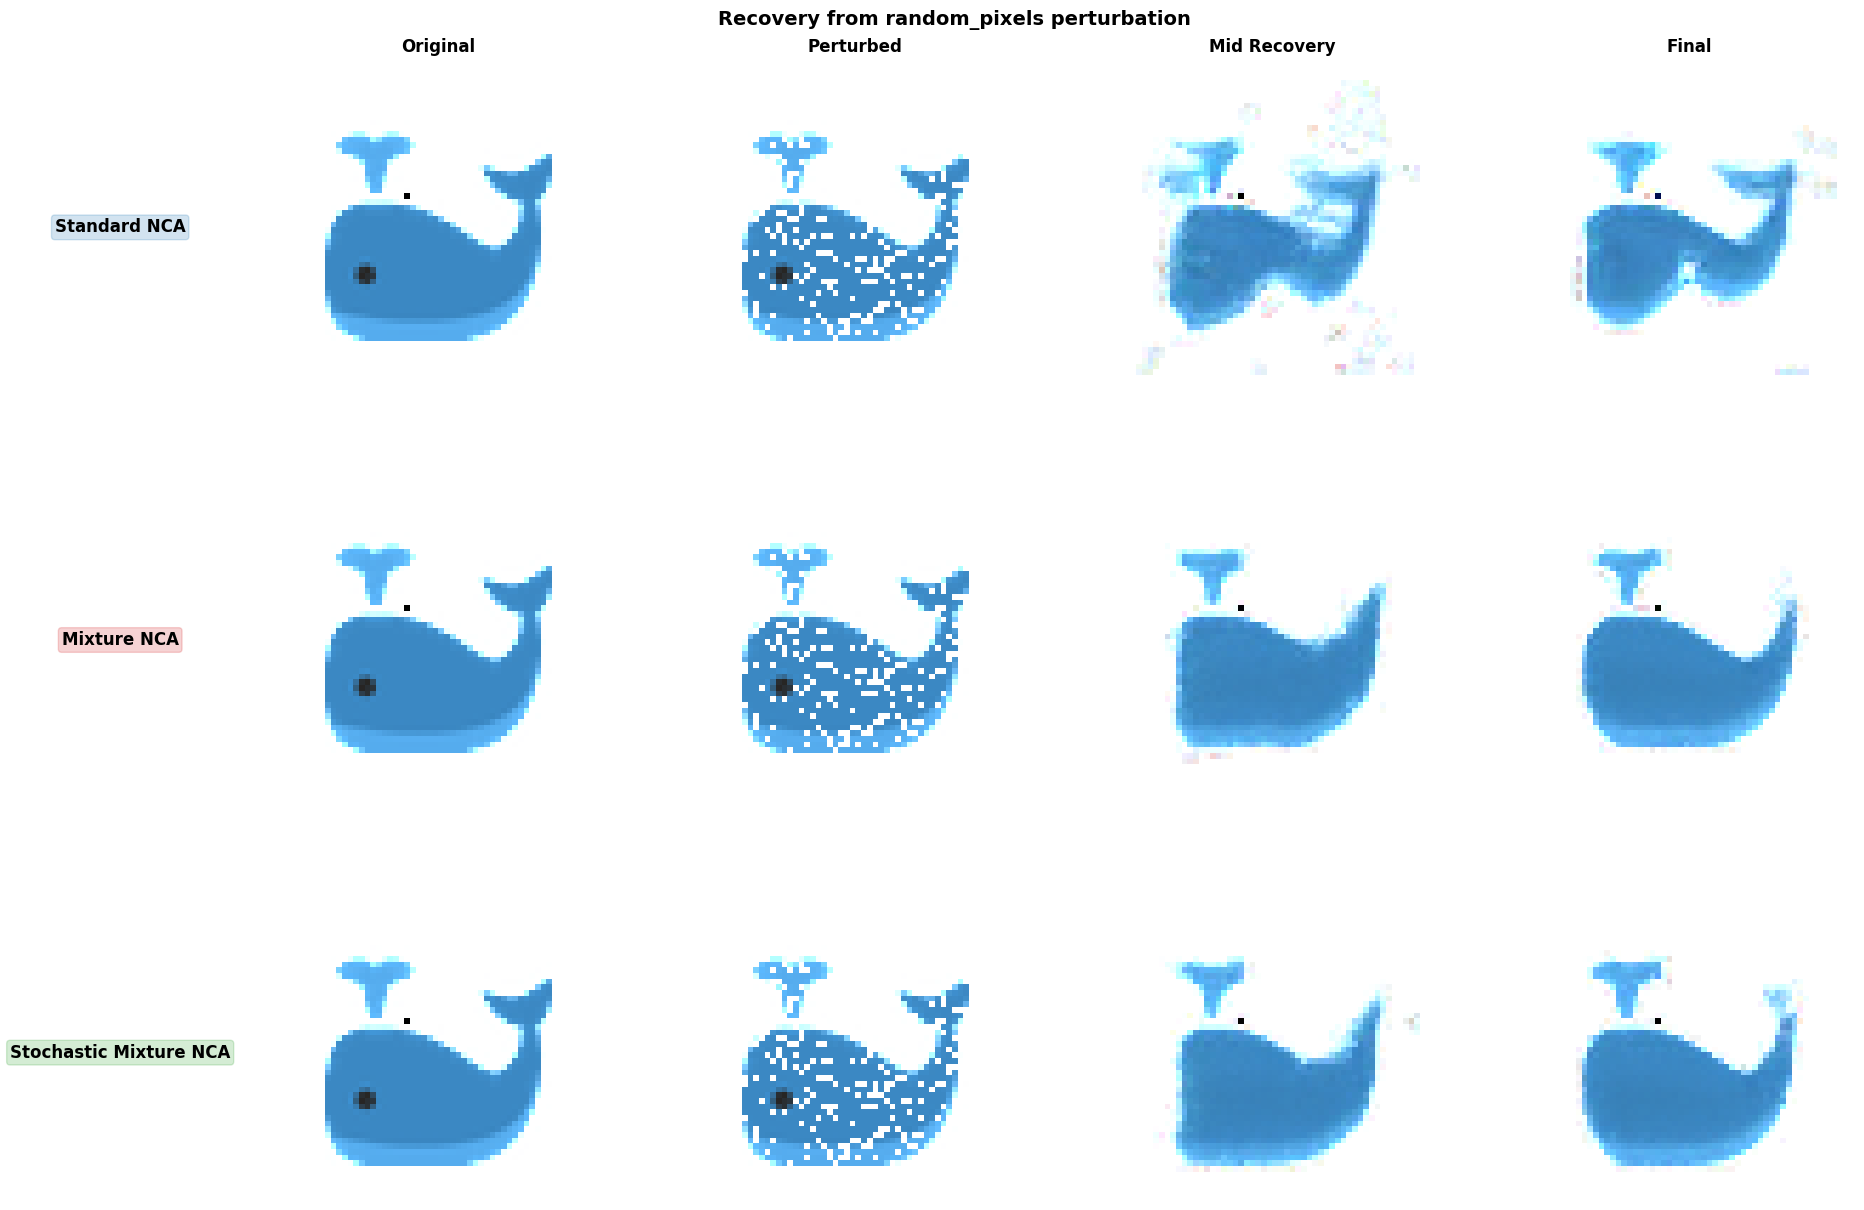

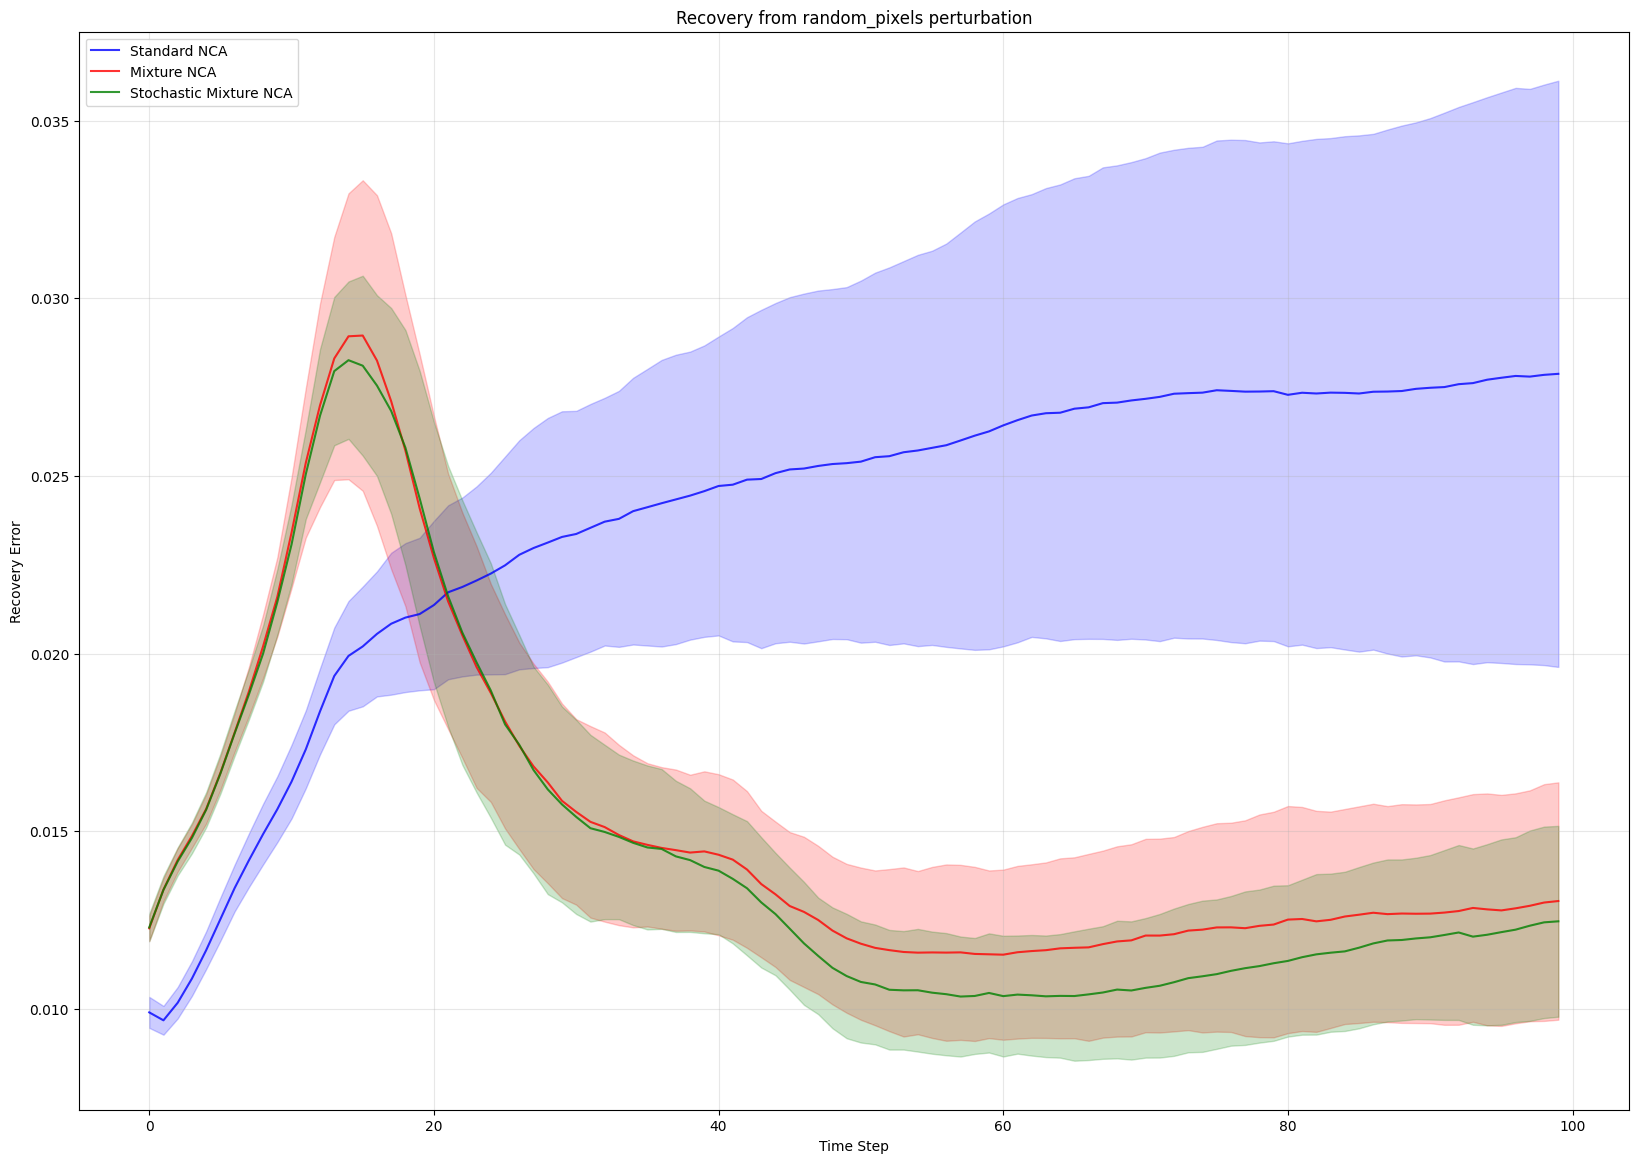

In [57]:
# Test with different numbers of masked pixels
pixel_counts = [1000, 2500, 5000]  # Test different levels of damage
results = {}

# Compute results
for n_pixels in pixel_counts:
    results[n_pixels] = robustness_analysis.compute_robustness_metrics(
        init_state_nca,
        perturbation_type='random_pixels',
        steps=100,
        seed=SEED_LOC,
        n_runs=30,
        n_pixels=n_pixels
    )

# Create figure with subplots
fig, axes = plt.subplots(len(pixel_counts), 1, figsize=(15, 5*len(pixel_counts)))

# Plot recovery trajectories for different pixel counts
for i, n_pixels in enumerate(pixel_counts):
    robustness_analysis.visualize_stored_results(
        results[n_pixels], 
        plot_type='error',
        ax=axes[i]
    )
    axes[i].set_title(f'Recovery from {n_pixels} masked pixels')

plt.tight_layout()
plt.show()

# Print summary statistics
for n_pixels in pixel_counts:
    print(f"\nResults for {n_pixels} masked pixels:")
    robustness_analysis.print_summary_statistics(results[n_pixels])

# Compare single case in detail
detailed_results = robustness_analysis.compute_robustness_metrics(
    init_state_nca,
    perturbation_type='random_pixels',
    steps=100,
    seed=SEED_LOC,
    n_runs=30,
    n_pixels=500
)

# Visualize detailed trajectory
robustness_analysis.visualize_stored_results(detailed_results, plot_type='trajectories')
robustness_analysis.visualize_stored_results(detailed_results, plot_type='error')

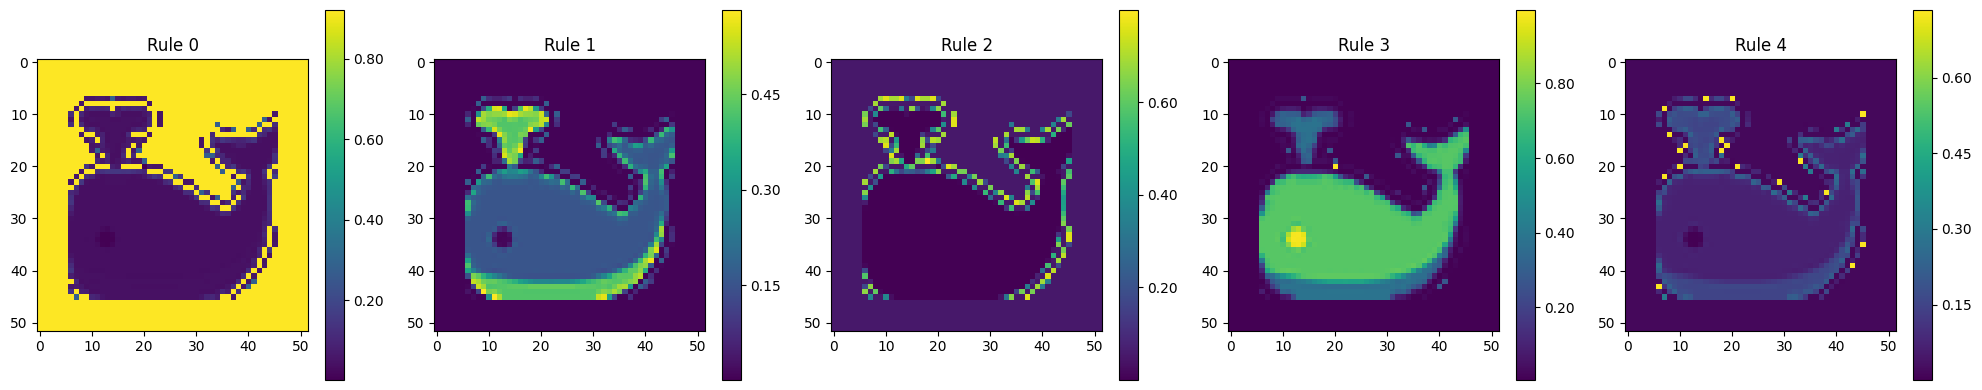

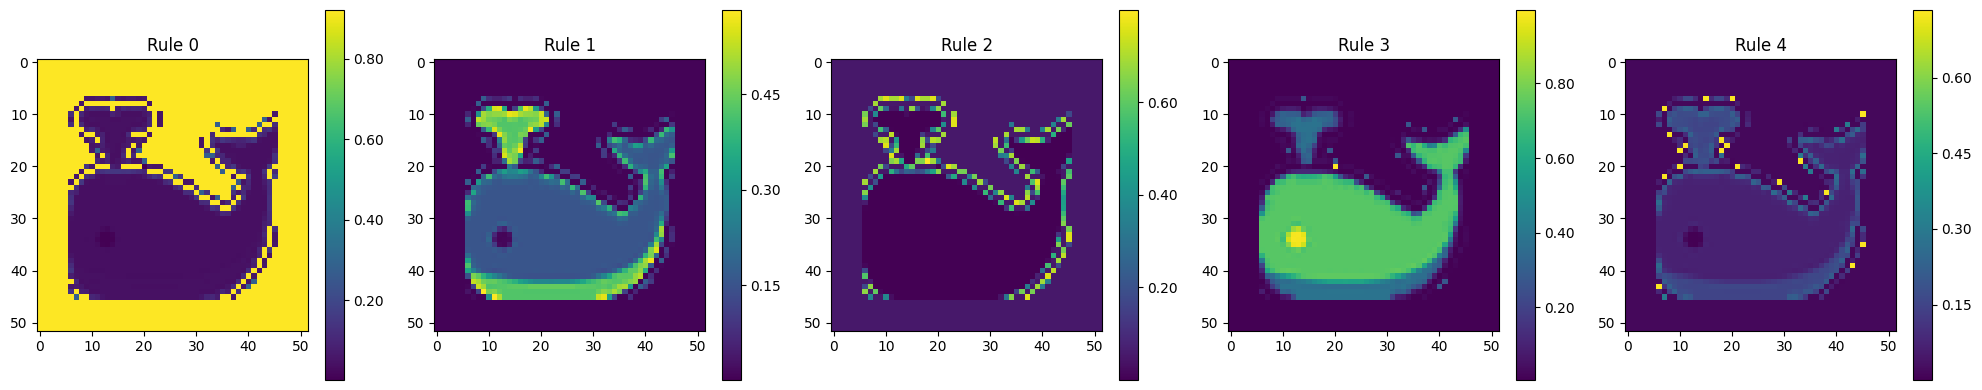

In [58]:
# visualize rule assignment in mixture nca
model_mix.visualize_rule_assignments(init_state_nca)

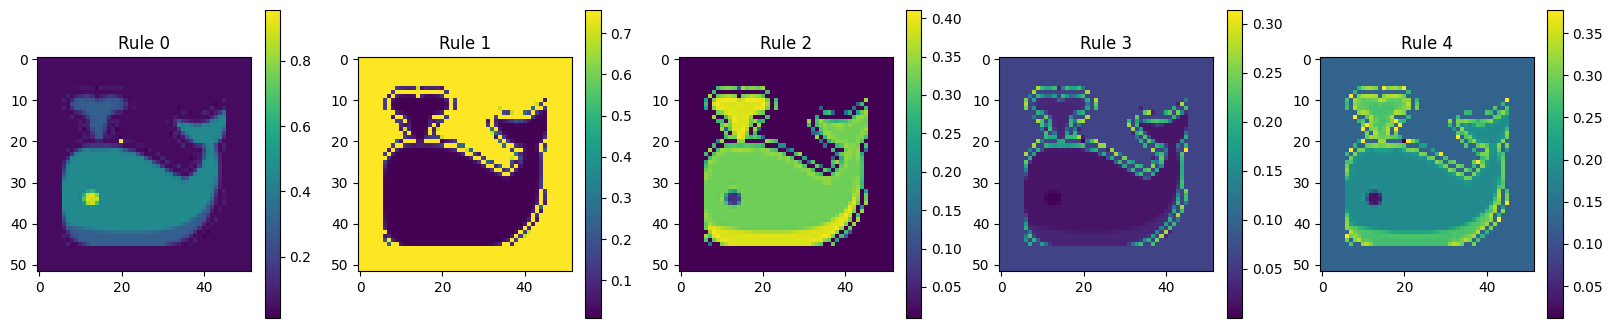

In [42]:
# visualize rule assignment in stochastic mixture nca
stochastic_mixture_model.visualize_rule_assignments(init_state_nca)